# Dropout

In [1]:
# Setup plotting
import matplotlib.pyplot as plt
# from learntools.deep_learning_intro.dltools import animate_sgd
print(plt.style.available)
plt.style.use('seaborn-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')


['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

spotify = pd.read_csv('./data/spotify.csv')

X = spotify.copy().dropna()
y = X.pop('track_popularity')
artists = X['track_artist']

features_num = ['danceability', 'energy', 'key', 'loudness', 'mode',
                'speechiness', 'acousticness', 'instrumentalness',
                'liveness', 'valence', 'tempo', 'duration_ms']
features_cat = ['playlist_genre']

preprocessor = make_column_transformer(
    (StandardScaler(), features_num),
    (OneHotEncoder(), features_cat),
)

# We'll do a "grouped" split to keep all of an artist's songs in one
# split or the other. This is to help prevent signal leakage.
def group_split(X, y, group, train_size=0.75):
    splitter = GroupShuffleSplit(train_size=train_size)
    train, test = next(splitter.split(X, y, groups=group))
    return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])

X_train, X_valid, y_train, y_valid = group_split(X, y, artists)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
y_train = y_train / 100 # popularity is on a scale 0-100, so this rescales to 0-1.
y_valid = y_valid / 100

input_shape = [X_train.shape[1]]
print("Input shape: {}".format(input_shape))

Input shape: [18]


In [4]:
# YOUR CODE HERE: Add two 30% dropout layers, one after 128 and one after 64
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1)
])

Minimum Validation Loss: 0.1942


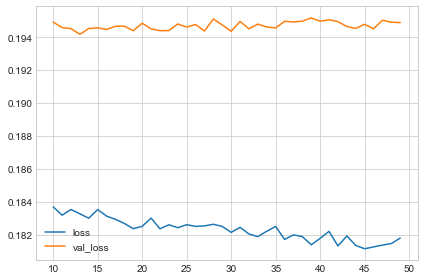

In [7]:
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    verbose=0,
)
history_df = pd.DataFrame(history.history)
history_df.loc[10:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

# Batch normalization

In [8]:
import pandas as pd

concrete = pd.read_csv('./data/concrete.csv')
df = concrete.copy()

df_train = df.sample(frac=0.7, random_state=0)
df_valid = df.drop(df_train.index)

X_train = df_train.drop('CompressiveStrength', axis=1)
X_valid = df_valid.drop('CompressiveStrength', axis=1)
y_train = df_train['CompressiveStrength']
y_valid = df_valid['CompressiveStrength']

input_shape = [X_train.shape[1]]

Minimum Validation Loss: nan


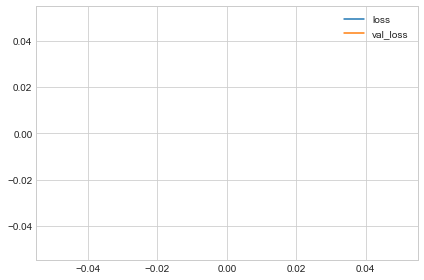

In [10]:
model = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=input_shape),
    layers.Dense(512, activation='relu'),    
    layers.Dense(512, activation='relu'),
    layers.Dense(1),
])
model.compile(
    optimizer='sgd', # SGD is more sensitive to differences of scale
    loss='mae',
    metrics=['mae'],
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=64,
    epochs=100,
    verbose=0,
)

history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print(("Minimum Validation Loss: {:0.4f}").format(history_df['val_loss'].min()))

In [12]:
# YOUR CODE HERE: Add a BatchNormalization layer before each Dense layer
model = keras.Sequential([
    layers.BatchNormalization(input_shape=input_shape),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(1),
])


Minimum Validation Loss: 4.1497


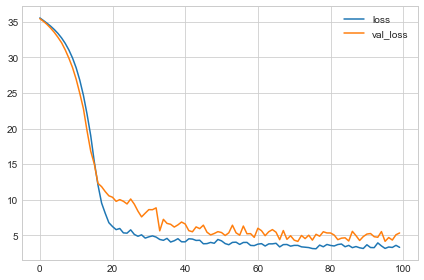

In [13]:
model.compile(
    optimizer='sgd',
    loss='mae',
    metrics=['mae'],
)
EPOCHS = 100
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=64,
    epochs=EPOCHS,
    verbose=0,
)

history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print(("Minimum Validation Loss: {:0.4f}").format(history_df['val_loss'].min()))